# A2: NeuralNetwork Class

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1">Requirements</a></span></li><li><span><a href="#Code-for-NeuralNetwork-Class" data-toc-modified-id="Code-for-NeuralNetwork-Class-2">Code for <code>NeuralNetwork</code> Class</a></span></li><li><span><a href="#Example-Results" data-toc-modified-id="Example-Results-3">Example Results</a></span></li><li><span><a href="#Application-to-Boston-Housing-Data" data-toc-modified-id="Application-to-Boston-Housing-Data-4">Application to Boston Housing Data</a></span></li></ul></div>

## Requirements

In this assignment, you will complete the implementation of the `NeuralNetwork` class, starting with the code included in the next code cell.  Your implementation must meet the requirements described in the doc-strings.

Download [optimizers.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/optimizers.tar) and extract `optimizers.py` for use in this assignment.

Then apply your `NeuralNetwork` class to the problem of predicting the value of houses in Boston as described below.

## Code for `NeuralNetwork` Class

In [3]:
%%writefile neuralnetwork.py
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 13 09:55:02 2021

@author: chen
"""
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import time  # for sleep
import IPython.display as ipd  # for display and clear_output
from IPython.display import display, clear_output  # for the following animation
import os
import copy
import signal
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
import optimizers as opt
import pandas  # for reading csv file





class NeuralNetwork():
    """
    A class that represents a neural network for nonlinear regression

    Attributes
    ----------
    n_inputs : int
        The number of values in each sample
    n_hidden_units_by_layers: list of ints, or empty
        The number of units in each hidden layer.
        Its length specifies the number of hidden layers.
    n_outputs: int
        The number of units in output layer
    all_weights : one-dimensional numpy array
        Contains all weights of the network as a vector
    Ws : list of two-dimensional numpy arrays
        Contains matrices of weights in each layer,
        as views into all_weights
    all_gradients : one-dimensional numpy array
        Contains all gradients of mean square error with
        respect to each weight in the network as a vector
    Grads : list of two-dimensional numpy arrays
        Contains matrices of gradients weights in each layer,
        as views into all_gradients
    total_epochs : int
        Total number of epochs trained so far
    error_trace : list
        Mean square error (standardized) after each epoch
    X_means : one-dimensional numpy array
        Means of the components, or features, across samples
    X_stds : one-dimensional numpy array
        Standard deviations of the components, or features, across samples
    T_means : one-dimensional numpy array
        Means of the components of the targets, across samples
    T_stds : one-dimensional numpy array
        Standard deviations of the components of the targets, across samples
        
    Methods
    -------
    make_weights_and_views(shapes)
        Creates all initial weights and views for each layer

    train(X, T, n_epochs, method='sgd', learning_rate=None, verbose=True)
        Trains the network using samples by rows in X and T

    use(X)
        Applies network to inputs X and returns network's output
    """ 
    def __init__(self, n_inputs, n_hidden_units_by_layers, n_outputs):

        
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_hidden_units_by_layers = n_hidden_units_by_layers
        self.Ws= []
        self.all_weights=np.empty([0,1])
        self.shapes=[]
 
    
        layer_n=n_inputs
        for layerI in range(len(self.n_hidden_units_by_layers)):
            layerI_N=self.n_hidden_units_by_layers[layerI]
            self.shapes.append([1 + layer_n, layerI_N])
            layer_n=layerI_N
        self.shapes.append([1 + layer_n, n_outputs])
        
        self.make_weights_and_views(self.shapes)
        self.all_gradients = []
        self.Grads = []
        self.total_epochs = 0
        self.error_trace = []
        self.X_means = None
        self.X_stds = None
        self.T_means = None
        self.T_stds = None
        self.Ys=None

    def make_weights_and_views(self, shapes):
        """Creates vector of all weights and views for each layer

        Parameters
        ----------
        shapes : list of pairs of ints
            Each pair is number of rows and columns of weights in each layer

        Returns
        -------
        Vector of all weights, and list of views into this vector for each layer
        """

        # Create one-dimensional numpy array of all weights with random initial values
        #  ...

        # Build list of views by reshaping corresponding elements
        # from vector of all weights into correct shape for each layer.        
        # ...
 
        for layerI in range(len(shapes)):
            shapeX=shapes[layerI][0]
            shapeY=shapes[layerI][1]
            wI=1 / np.sqrt(shapeX) * np.random.uniform(-1, 1, size=(shapeX, shapeY))
            self.Ws.append(wI)
#           haha=np.vstack((self.all_weights,wI.reshape(-1,1)))
            self.all_weights=np.vstack((self.all_weights,wI.reshape(-1,1))) 
 
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, ' + \
            f'{self.n_hidden_units_by_layers}, {self.n_outputs})'

    def __str__(self):
        s = self.__repr__()
        if self.total_epochs > 0:
            s += f'\n Trained for {self.total_epochs} epochs.'
            s += f'\n Final standardized training error {self.error_trace[-1]:.4g}.'
        return s
 
    def train(self, X, T, n_epochs, method='sgd', learning_rate=None, verbose=True):
        """Updates the weights 
        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components
        n_epochs : int
            Number of passes to take through all samples
        method : str
            'sgd', 'adam', or 'scg'
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        verbose: boolean
            If True, progress is shown with print statements
        """

        # Calculate and assign standardization parameters
        # ...
        
        self.X_means = np.mean(X, axis=0)
        self.X_stds = np.std(X, axis=0)
        self.T_means = np.mean(T, axis=0)
        self.T_stds = np.std(T, axis=0)
        # Standardize X and T

        X = (X - self.X_means) / self.X_stds
        T = (T - self.T_means) / self.T_stds
 
        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = opt.Optimizers(self.all_weights)

        error_convert_f = lambda err: (np.sqrt(err) * self.T_stds)[0]
        
        # Call the requested optimizer method to train the weights.

        if method == 'sgd':
            error_trace=optimizer.sgd(self.error_f, self.gradient_f,fargs=[X,T],error_convert_f=error_convert_f,learning_rate=learning_rate,n_epochs=n_epochs,verbose=True)
        elif method == 'adam':
            error_trace=optimizer.adam(self.error_f, self.gradient_f,fargs=[X,T],error_convert_f=error_convert_f,learning_rate=learning_rate,n_epochs=n_epochs)
        elif method == 'scg':
            error_trace=optimizer.scg(self.error_f, self.gradient_f,fargs=[X,T],error_convert_f=error_convert_f,n_epochs=n_epochs)
        else:
            raise Exception("method must be 'sgd', 'adam', or 'scg'")
 
    
        self.total_epochs += len(error_trace)
        self.error_trace += error_trace



        self._forward(X)
        error = (T - self.Ys[-1]) * self.T_stds 
#       plt.plot(X, self.Ys[-1], 'o-', label='Model ')
#       errors.append(nnet.get_error_trace())
#       plt.plot(X, T, '*-', label='Train')
#       print(self.all_weights[20])
#       plt.plot(self.all_weights, '*-', label='w')

#       plt.show()

#       plt.draw()
#       plt.pause(0.00000001)
#       plt.clf()
 
        
        
        
        
        # Return neural network object to allow applying other methods
        # after training, such as:    Y = nnet.train(X, T, 100, 0.01).use(X)

        return self

    def addOnes(self,A):
        return np.insert(A, 0, 1, axis=1)
    
    def _forward(self, X):
        """Calculate outputs of each layer given inputs in X
        
        Parameters
        ----------
        X : input samples, standardized

        Returns
        -------
        Outputs of all layers as list
        """
        # unpack self.all_weights to self.Ws
        i=0
        for layerI in range(len(self.shapes)):
            shapeX=self.shapes[layerI][0]
            shapeY=self.shapes[layerI][1]
            self.Ws[layerI]=self.all_weights[i:i+shapeX*shapeY].reshape(shapeX,shapeY)
            i+=shapeX*shapeY
        
        self.Ys=[]
        for layerI in range(len(self.n_hidden_units_by_layers)):
            X=np.tanh(self.addOnes(X) @ self.Ws[layerI])
            self.Ys.append(X)
        X=self.addOnes(X)@self.Ws[-1]
        self.Ys.append(X)
        # Append output of each layer to list in self.Ys, then return it.
        # ...

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        """Calculate output of net and its mean squared error 

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components

        Returns
        -------
        Mean square error as scalar float that is the mean
        square error over all samples
        """
        self._forward(X)
        error = (T - self.Ys[-1]) * self.T_stds 
        self.error_trace.append(error)
        summation = 0  #variable to store the summation of differences
        n = len(error) #finding total number of items in list
        for i in range (n):  #looping through each element of the list
            difference = error[i]**2
            summation +=difference  
        MSE = summation/n  #dividing summation by total values to obtain average
        
 
# # #       errors.append(nnet.get_error_trace())
 
# # #       plt.plot(self.all_weights, '*-', label='w')

# # #       plt.show()


#         plt.plot(self.Ys[-1], 'o-', label='Model ')
#         plt.plot(T, '*-', label='Train')

#         plt.draw()
#         plt.pause(0.00001)
#         plt.clf()
 
 
        # Call _forward, calculate mean square error and return it.
        # ...
        return MSE
        
        # Call _forward, calculate mean square error and return it.
        # ...

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        """Returns gradient wrt all weights. Assumes _forward already called.

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components

        Returns
        -------
        Vector of gradients of mean square error wrt all weights
        """
 
        self._forward( X)
        # Assumes forward_pass just called with layer outputs saved in self.Ys.
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        n_layers = len(self.n_hidden_units_by_layers) + 1

        # D is delta matrix to be back propagated
        D = (T - self.Ys[-1])  
        self.Grads =  [None] *n_layers

        # Step backwards through the layers to back-propagate the error (D)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
 
            # Back-propagate this layer's delta to previous layer
            if layeri > 0:
                self.Grads[layeri]= -self.addOnes(self.Ys[layeri-1]).T@D
                D =D@self.Ws[layeri][1:,:].T*(1-self.Ys[layeri-1]**2)  
            else:
                self.Grads[layeri]= -self.addOnes(X).T@D
         
        
        self.all_gradients=np.empty([0,1])
        
        for layerI in range(n_layers):
             
#           haha=np.vstack((self.all_weights,wI.reshape(-1,1)))
            self.all_gradients=np.vstack((self.all_gradients,self.Grads[layerI].reshape(-1,1))) 
            
            
            
            
        return self.all_gradients

    def use(self, X):
        """Return the output of the network for input samples as rows in X

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components, unstandardized

        Returns
        -------
        Output of neural network, unstandardized, as numpy array
        of shape  number of samples  x  number of outputs
        """
 
        X=(X-self.X_means)/self.X_stds
        self._forward( X)
        Y=self.Ys[-1]
        Y=Y*self.T_stds+self.T_means
        return Y 
 
    def get_error_trace(self):
        """Returns list of standardized mean square error for each epoch"""
        return self.error_trace

Overwriting neuralnetwork.py


## Example Results

Here we test the `NeuralNetwork` class with some simple data.  


In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetwork as nn

#%% main functions
 
X = np.arange(-2, 2, 0.05).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

errors = []
n_epochs = 1000
method_rhos = [  
    
#                 ('adam', 0.01),
                ('scg', None)]
 
for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(X.shape[1], [30, 30], 1)
    nnet.train(X, T, n_epochs, method=method, learning_rate=rho)
    Y = nnet.use(X)
    plt.plot(X, Y, 'o-', label='Model ' + method)
    plt.plot(X, T, 'o', label='Train')
    errors.append(nnet.get_error_trace())
    plt.show()
    exit()


plt.plot(X, T, 'o', label='Train')
plt.xlabel('X')
plt.ylabel('T or Y')
plt.legend();

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1021 is different from 1)

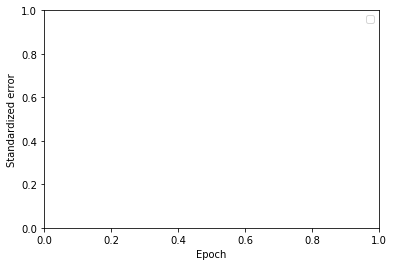

In [5]:
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

Your results will not be the same, but your code should complete and make plots somewhat similar to these.

## Application to Boston Housing Data

Download data from [Boston House Data at Kaggle](https://www.kaggle.com/fedesoriano/the-boston-houseprice-data). Read it into python using the `pandas.read_csv` function.  Assign the first 13 columns as inputs to `X` and the final column as target values to `T`.  Make sure `T` is two-dimensional.

Before training your neural networks, partition the data into training and testing partitions, as shown here.

In [6]:
def partition(X, T, train_fraction):
    n_samples = X.shape[0]
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    
    n_train = round(n_amples * train_fraction)
    
    Xtrain = X[rows[:ntrain], :]
    Ttrain = T[rows[:ntrain], :]
    Xtest = X[rows[ntrain:], :]
    Ttest = T[rows[ntrain:], :]
    
def rmse(T, Y):
    return np.sqrt(np.mean((T - Y)**2))

In [7]:
# Assuming you have assigned `X` and `T` correctly.

Xtrain, Train, Xtest, Ttest = partition(X, T, 0.8)  

NameError: name 'n_amples' is not defined

Write and run code using your `NeuralNetwork` class to model the Boston housing data. Experiment with all three optimization methods and a variety of neural network structures (numbers of hidden layer and units), learning rates, and numbers of epochs. Show results for at least three different network structures, learning rates, and numbers of epochs for each method.  Show your results using print statements that include the method, network structure, number of epochs, learning rate, and RMSE on training data and RMSE on testing data.

Try to find good values for the RMSE on testing data.  Discuss your results, including how good you think the RMSE values are by considering the range of house values given in the data. 

# Grading

<font color='red'>A2grader.tar is coming soon.</font>

Your notebook will be run and graded automatically. Test this grading process by first downloading [A2grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A2grader.tar) and extract `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  The remaining 20 points will be based on your discussion of this assignment.

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'Lastname-A2.ipynb' with 'Lastname' being your last name, and then save this notebook.

In [8]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Chen-A2.ipynb' and storing in notebookcode.py


[NbConvertApp] Converting notebook Chen-A2.ipynb to script


Removing all statements that are not function or class defs or import statements.

Testing

    import neuralnetwork as nn

    n_inputs = 3
    n_hiddens = [10, 20]
    n_outputs = 2
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    
    nnet = nn.NeuralNetwork(n_inputs, n_hiddens, n_outputs)
    nnet.all_weights = 0.1  # set all weights to 0.1
    nnet.X_means = np.mean(X, axis=0)
    nnet.X_stds = np.std(X, axis=0)
    nnet.T_means = np.zeros((n_samples, n_outputs))
    nnet.T_stds = np.ones((n_samples, n_outputs))
    
    Y = nnet.use(X)


--- 40/40 points. Returned correct value.

Testing
    n_inputs = 3
    n_hiddens = [10, 500, 6, 3]
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    T = np.log(X + 0.1)
    n_outputs = T.shape[1]
    
    def rmse(A, B):
        return np.sqrt(np.mean((A - B)**2))

    results = []
    for rep in range(20):
        nnet = nn.NeuralNetwork(n_inputs, n

Adam: Epoch 2500 ObjectiveF=0.01003
Adam: Epoch 3000 ObjectiveF=0.00536
Adam: Epoch 3500 ObjectiveF=0.00422
Adam: Epoch 4000 ObjectiveF=0.00324
Adam: Epoch 4500 ObjectiveF=0.00231
Adam: Epoch 5000 ObjectiveF=0.00217
Net 19 RMSE 0.00205
Adam: Epoch 500 ObjectiveF=0.15981
Adam: Epoch 1000 ObjectiveF=0.04967
Adam: Epoch 1500 ObjectiveF=0.01712
Adam: Epoch 2000 ObjectiveF=0.00979
Adam: Epoch 2500 ObjectiveF=0.00717
Adam: Epoch 3000 ObjectiveF=0.00543
Adam: Epoch 3500 ObjectiveF=0.00792
Adam: Epoch 4000 ObjectiveF=0.00499
Adam: Epoch 4500 ObjectiveF=0.00464
Adam: Epoch 5000 ObjectiveF=0.00407
Net 20 RMSE 0.00282
0.0014976705666430226

--- 40/40 points. Returned correct value.

HW Execution Grade is 80 / 80

 __ / 20 Results and discussion for Boston housing data.

HW FINAL GRADE is  _  / 100

Extra Credit:

Apply your functions to a data set from the UCI Machine Learning Repository.
Explain your steps and results in markdown cells.


HW EXTRA CREDIT is 0 / 1


<Figure size 432x288 with 0 Axes>

# Check-In

Do not include this section in your notebook.

Name your notebook ```Lastname-A2.ipynb```.  So, for me it would be ```Anderson-A2.ipynb```.  Submit the file using the ```Assignment 2``` link on [Canvas](https://colostate.instructure.com/courses/131494).

# Extra Credit

Apply your multilayer neural network code to a regression problem using data that you choose 
from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets.php). Pick a dataset that
is listed as being appropriate for regression.